In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
import copy

print("Libraries imported successfully.")

Libraries imported successfully.


In [2]:
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

print(f"Random seed set to {SEED}.")

Random seed set to 42.


In [3]:
EPOCHS = 200 # Non-linear data might need more epochs
BATCH_SIZE = 32
LR = 0.001
N_SAMPLES = 1000 # More samples
NOISE = 0.2 # Amount of noise in the moons

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


Data loaded. Features shape: (1000, 2), Target shape: (1000,)
Class distribution: [500 500]


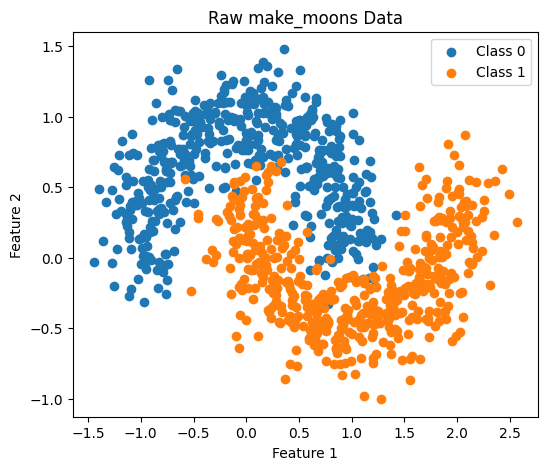

In [4]:
X, y = make_moons(n_samples=N_SAMPLES, noise=NOISE, random_state=SEED)

print(f"Data loaded. Features shape: {X.shape}, Target shape: {y.shape}")
print(f"Class distribution: {np.bincount(y)}")

# Plot the raw data
plt.figure(figsize=(6, 5))
plt.scatter(X[y==0, 0], X[y==0, 1], label="Class 0")
plt.scatter(X[y==1, 0], X[y==1, 1], label="Class 1")
plt.title("Raw make_moons Data")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend()
plt.show()

In [5]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("Features scaled using StandardScaler.")

Features scaled using StandardScaler.


In [6]:
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=SEED, stratify=y
)

print(f"Data split complete.")
print(f"Training samples: {X_train.shape[0]}")
print(f"Testing samples: {X_test.shape[0]}")

Data split complete.
Training samples: 800
Testing samples: 200


In [7]:
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)

y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

print("Data converted to PyTorch tensors.")
print(f"y_train_tensor shape: {y_train_tensor.shape}, dtype: {y_train_tensor.dtype}")

Data converted to PyTorch tensors.
y_train_tensor shape: torch.Size([800, 1]), dtype: torch.float32


In [8]:
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"DataLoaders created with batch size {BATCH_SIZE}.")

DataLoaders created with batch size 32.


In [9]:
class BinaryClassifierMLP(nn.Module):
    def __init__(self, input_dim):
        super(BinaryClassifierMLP, self).__init__()
        self.layer_1 = nn.Linear(input_dim, 16)
        self.relu_1 = nn.ReLU()
        self.layer_2 = nn.Linear(16, 16)
        self.relu_2 = nn.ReLU()
        self.layer_out = nn.Linear(16, 1) # Output raw logits

    def forward(self, x):
        x = self.layer_1(x)
        x = self.relu_1(x)
        x = self.layer_2(x)
        x = self.relu_2(x)
        x = self.layer_out(x)
        return x

# Get input dimension from the data
input_dim = X_train.shape[1] # Should be 2
model = BinaryClassifierMLP(input_dim)

print("Model architecture (MLP):")
print(model)

Model architecture (MLP):
BinaryClassifierMLP(
  (layer_1): Linear(in_features=2, out_features=16, bias=True)
  (relu_1): ReLU()
  (layer_2): Linear(in_features=16, out_features=16, bias=True)
  (relu_2): ReLU()
  (layer_out): Linear(in_features=16, out_features=1, bias=True)
)


In [10]:
model = BinaryClassifierMLP(input_dim).to(device)

# Loss function: BCEWithLogitsLoss
criterion = nn.BCEWithLogitsLoss()

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=LR)

print("Model, Loss Function (BCEWithLogitsLoss), and Optimizer (Adam) initialized.")
print(f"Model moved to {device}.")

Model, Loss Function (BCEWithLogitsLoss), and Optimizer (Adam) initialized.
Model moved to cpu.


In [11]:
train_losses = []
test_losses = []
best_test_loss = float('inf')
best_model_weights = None

print(f"Starting training for {EPOCHS} epochs...")

for epoch in range(EPOCHS):
    # --- Training Phase ---
    model.train()
    running_train_loss = 0.0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        # 1. Zero gradients
        optimizer.zero_grad()

        # 2. Forward pass (get logits)
        outputs = model(inputs)

        # 3. Calculate loss
        loss = criterion(outputs, labels)

        # 4. Backward pass
        loss.backward()

        # 5. Update weights
        optimizer.step()

        running_train_loss += loss.item() * inputs.size(0)

    epoch_train_loss = running_train_loss / len(train_loader.dataset)
    train_losses.append(epoch_train_loss)

    # --- Validation Phase ---
    model.eval()
    running_test_loss = 0.0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_test_loss += loss.item() * inputs.size(0)

    epoch_test_loss = running_test_loss / len(test_loader.dataset)
    test_losses.append(epoch_test_loss)

    # Save the best model
    if epoch_test_loss < best_test_loss:
        best_test_loss = epoch_test_loss
        best_model_weights = copy.deepcopy(model.state_dict())

    if (epoch + 1) % 20 == 0:
        print(f"Epoch {epoch+1}/{EPOCHS} | Train Loss: {epoch_train_loss:.4f} | Test Loss: {epoch_test_loss:.4f}")

print("Training finished.")

# Load the best model weights
model.load_state_dict(best_model_weights)
print(f"Best model weights loaded (Test Loss: {best_test_loss:.4f})")

Starting training for 200 epochs...
Epoch 20/200 | Train Loss: 0.2786 | Test Loss: 0.2060
Epoch 40/200 | Train Loss: 0.1827 | Test Loss: 0.1280
Epoch 60/200 | Train Loss: 0.1151 | Test Loss: 0.0737
Epoch 80/200 | Train Loss: 0.0907 | Test Loss: 0.0500
Epoch 100/200 | Train Loss: 0.0794 | Test Loss: 0.0397
Epoch 120/200 | Train Loss: 0.0739 | Test Loss: 0.0342
Epoch 140/200 | Train Loss: 0.0709 | Test Loss: 0.0326
Epoch 160/200 | Train Loss: 0.0697 | Test Loss: 0.0306
Epoch 180/200 | Train Loss: 0.0686 | Test Loss: 0.0302
Epoch 200/200 | Train Loss: 0.0679 | Test Loss: 0.0295
Training finished.
Best model weights loaded (Test Loss: 0.0285)


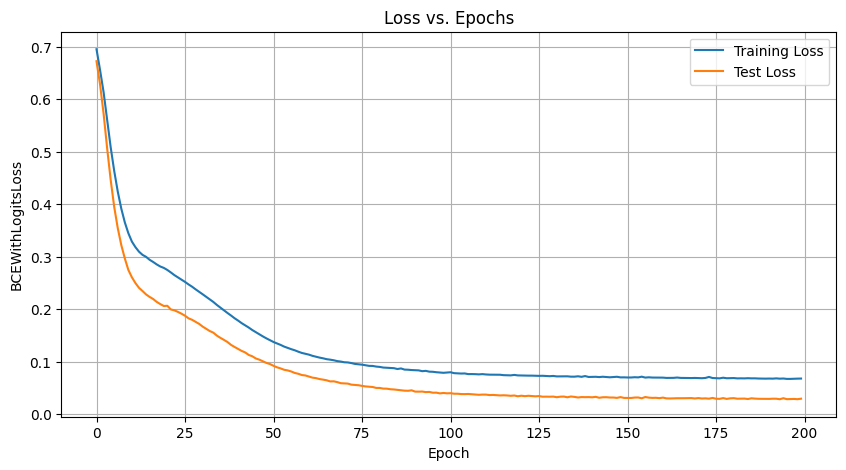

In [12]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label='Test Loss')
plt.title('Loss vs. Epochs')
plt.xlabel('Epoch')
plt.ylabel('BCEWithLogitsLoss')
plt.legend()
plt.grid(True)
plt.show()


Final Model Evaluation on Test Set:
Accuracy: 99.50%
Plotting decision boundary on test set...


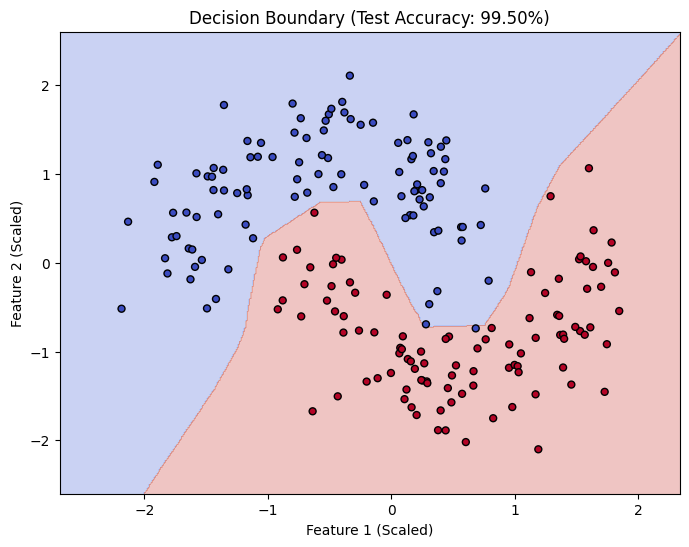

BinaryClassifierMLP(
  (layer_1): Linear(in_features=2, out_features=16, bias=True)
  (relu_1): ReLU()
  (layer_2): Linear(in_features=16, out_features=16, bias=True)
  (relu_2): ReLU()
  (layer_out): Linear(in_features=16, out_features=1, bias=True)
)

In [13]:
model.eval()
all_labels = []
all_preds = []

with torch.no_grad():
    # We can use the full test tensors directly
    test_outputs = model(X_test_tensor.to(device))
    test_probs = torch.sigmoid(test_outputs)
    test_preds = (test_probs > 0.5).float() # Binary predictions

    all_preds = test_preds.cpu().numpy().flatten()
    all_labels = y_test_tensor.cpu().numpy().flatten()


# Calculate final accuracy
final_accuracy = accuracy_score(all_labels, all_preds)
print(f"\nFinal Model Evaluation on Test Set:")
print(f"Accuracy: {final_accuracy * 100:.2f}%")

# Helper function to plot the decision boundary
def plot_decision_boundary(model, X, y):
    model.eval()
    model.to('cpu') # Move model to CPU for this plotting part

    # Set min and max values and give some padding
    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
    h = 0.01

    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    grid_points = np.c_[xx.ravel(), yy.ravel()]

    # Convert grid to tensor
    grid_tensor = torch.tensor(grid_points, dtype=torch.float32)

    # Get predictions for the grid
    with torch.no_grad():
        outputs = model(grid_tensor)
        probs = torch.sigmoid(outputs)
        Z = (probs > 0.5).float().numpy().reshape(xx.shape)

    # Plot the contour and training examples
    plt.figure(figsize=(8, 6))
    plt.contourf(xx, yy, Z, alpha=0.3, cmap=plt.cm.coolwarm)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=25,
                cmap=plt.cm.coolwarm, edgecolors='k')
    plt.title(f'Decision Boundary (Test Accuracy: {final_accuracy*100:.2f}%)')
    plt.xlabel('Feature 1 (Scaled)')
    plt.ylabel('Feature 2 (Scaled)')
    plt.show()

# Plot the decision boundary using the *test* data
print("Plotting decision boundary on test set...")
plot_decision_boundary(model, X_test, y_test)
model.to(device) # Move model back to device

In [14]:
MODEL_PATH = 'make_moons_model.pth'
torch.save(model.state_dict(), MODEL_PATH)

print(f"\nModel state dictionary saved to {MODEL_PATH}")


Model state dictionary saved to make_moons_model.pth
